In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
# Ignore specific warnings from sklearn about mismatched feature names
warnings.filterwarnings("ignore", category=UserWarning, message="X has feature names, but DecisionTreeRegressor was fitted without feature names")
import holidays
from datetime import timedelta

# Load the dataset from a Parquet file
dataset_path = './data/lumen/train.parquet'
df = pd.read_parquet(dataset_path)

# Convert date columns to datetime format for easier date manipulation
df['reservation_date'] = pd.to_datetime(df['reservation_date'])
df['date_from'] = pd.to_datetime(df['date_from'])
df['date_to'] = pd.to_datetime(df['date_to'])

# Remove the first two rows of the dataframe
df = df.iloc[2:]

# Filter data for reservations that have been checked out
checked_out_reservations = df[df['reservation_status'] == 'Checked-out']
df = checked_out_reservations.copy()

# Select rows where the stay date is within the booked period from date_from to date_to
df = df[(df['stay_date'] >= df['date_from']) & (df['stay_date'] <= df['date_to'])]

# Ensure all rows have the from date before or on the to date
df = df[df['date_from'] <= df['date_to']]

# Filter out any data where the reservation date is after the from date
df = df[df['reservation_date'] <= df['date_from']]


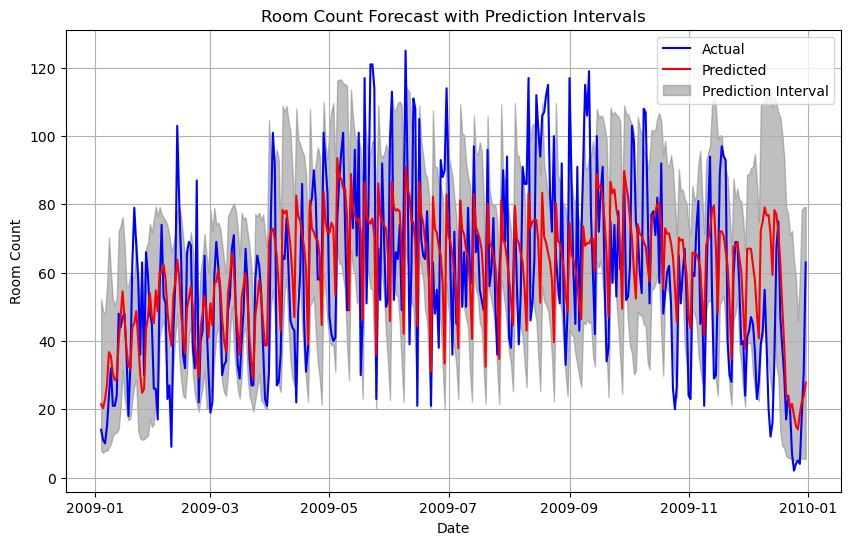

Percentage of actual values within predicted interval: 73.20%
Mean Squared Error: 460.63
Root Mean Squared Error: 21.46


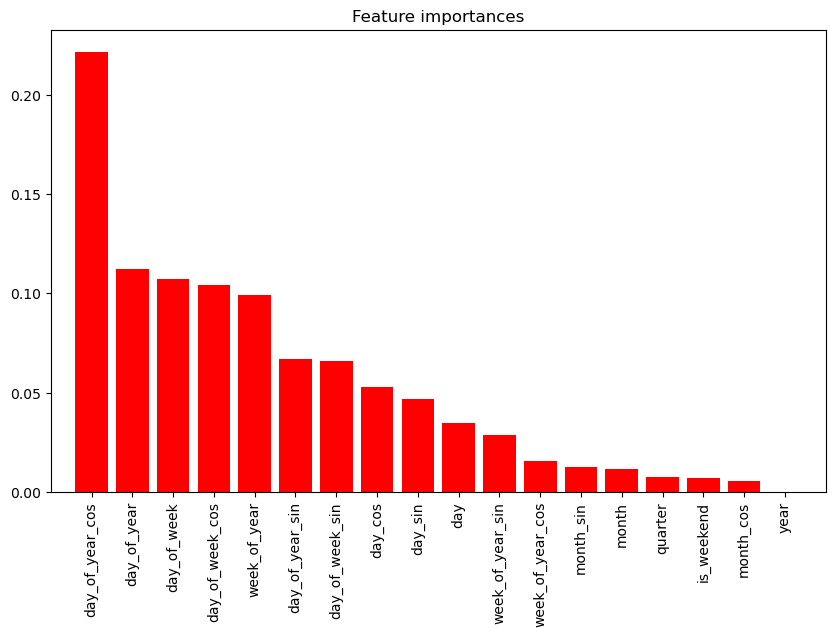

In [10]:
# Function to add cyclical features for handling periodic attributes.
def add_cyclical_features(df, col_name, max_val):
    df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / max_val)
    df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / max_val)
    return df

# Function to preprocess the data, resampling it daily and summing 'room_cnt'.
def preprocess_data(df):
    df['stay_date'] = pd.to_datetime(df['stay_date'])
    df = df.groupby('stay_date')['room_cnt'].sum().reset_index()
    df = df.set_index('stay_date').resample('D').sum().reset_index()
    return df

# Function to add various time-based features to the DataFrame.
def feature_engineering(df):
    df['year'] = df['stay_date'].dt.year - 2007
    df['month'] = df['stay_date'].dt.month
    df['day'] = df['stay_date'].dt.day
    df['week_of_year'] = df['stay_date'].dt.isocalendar().week
    df['quarter'] = df['stay_date'].dt.quarter
    df['day_of_week'] = df['stay_date'].dt.dayofweek
    df['day_of_year'] = df['stay_date'].dt.dayofyear
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    
    df = add_cyclical_features(df, 'day', 31)
    df = add_cyclical_features(df, 'week_of_year', 52)
    df = add_cyclical_features(df, 'month', 12)
    df = add_cyclical_features(df, 'day_of_week', 7)
    df = add_cyclical_features(df, 'day_of_year', 365)
    return df

# Function to split the dataset into training and testing sets based on a cutoff date.
def split_data(df, cutoff_date):
    cutoff_date = pd.to_datetime(cutoff_date)
    train_data = df[df['stay_date'] <= cutoff_date].copy()
    test_data = df[df['stay_date'] > cutoff_date].copy()
    features = [col for col in df.columns if col not in ['stay_date', 'room_cnt']]
    X_train = train_data[features]
    y_train = train_data['room_cnt']
    X_test = test_data[features]
    y_test = test_data['room_cnt']
    return train_data, test_data, X_train, y_train, X_test, y_test

# Function to train a RandomForestRegressor model.
def train_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=700, max_depth=6, min_samples_leaf=5, random_state=42)
    model.fit(X_train, y_train)
    return model

# Function to predict intervals for confidence using the RandomForest model.
def predict_intervals(model, X_test, percentile=95):
    predictions = np.array([tree.predict(X_test) for tree in model.estimators_])
    lower_bound = np.percentile(predictions, (100 - percentile) / 2, axis=0)
    upper_bound = np.percentile(predictions, 100 - (100 - percentile) / 2, axis=0)
    return lower_bound, upper_bound

# Function to plot the importance of each feature used in the RandomForest model.
def plot_feature_importance(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title("Feature importances")
    plt.bar(range(len(features)), importances[indices], color="r", align="center")
    plt.xticks(range(len(features)), np.array(features)[indices], rotation=90)
    plt.xlim([-1, len(features)])
    plt.show()

# Function to plot the prediction results with confidence intervals.
def plot_results(X_test_dates, y_test, y_pred, lower_bound, upper_bound):
    plt.figure(figsize=(10, 6))
    plt.plot(X_test_dates, y_test, label='Actual', color='blue')
    plt.plot(X_test_dates, y_pred, label='Predicted', color='red')
    plt.fill_between(X_test_dates, lower_bound, upper_bound, color='gray', alpha=0.5, label='Prediction Interval')
    plt.title('Room Count Forecast with Prediction Intervals')
    plt.xlabel('Date')
    plt.ylabel('Room Count')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to evaluate the precision of prediction intervals.
def evaluate_precision(y_test, lower_bound, upper_bound):
    within_interval = ((y_test >= lower_bound) & (y_test <= upper_bound)).mean()
    print(f"Percentage of actual values within predicted interval: {within_interval * 100:.2f}%")

# Function to calculate and display the Mean Squared Error and Root Mean Squared Error.
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")

# Process data, train model, and perform predictions
processed_data = preprocess_data(df)
processed_data = feature_engineering(processed_data)
train_data, test_data, X_train, y_train, X_test, y_test = split_data(processed_data, "2009-1-3")
model = train_model(X_train, y_train)
y_pred = model.predict(X_test)
lower_bound, upper_bound = predict_intervals(model, X_test)
plot_results(test_data['stay_date'], y_test, y_pred, lower_bound, upper_bound)
evaluate_precision(y_test, lower_bound, upper_bound)
evaluate_model(y_test, y_pred)
plot_feature_importance(model, X_train.columns)